In [1]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import fiona
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from geofeather import to_geofeather, from_geofeather

In [3]:
# Source data, TanDEM-X
tdx_hgt_source = os.path.join('/Users/arbailey/natcap/idb/data/source/nasa/Andros_12m_CHM_AGB','Andros_TDX_DEM_12m_EGM2008_CanopyHeight.tif')
# Working Directory
work_dir = '/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt'
os.chdir(work_dir)

In [4]:
# Import the previously joined point file layer (with SRTM & mangrove extents) into GeoDataFrame 
%time gliht_srtm_hmax95_mangroves4 = from_geofeather('gliht_srtm_hmax95_mangroves4.feather')
gliht_srtm_hmax95_mangroves4

CPU times: user 9min 52s, sys: 42.8 s, total: 10min 35s
Wall time: 10min 38s


,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m
0,0.0,788785.5,2787858.5,0,21282071,NaN,14210037,1,NaN,NaN,NaN,NaN,POINT (-78.13478 25.17915),1.586909
1,0.0,788781.5,2787857.5,0,21282071,NaN,14210036,2,NaN,NaN,NaN,NaN,POINT (-78.13482 25.17914),1.534521
2,0.0,788784.5,2787857.5,0,21282071,NaN,14210037,3,NaN,NaN,NaN,NaN,POINT (-78.13479 25.17914),1.539167
3,0.0,788776.5,2787856.5,0,21282070,NaN,14210036,4,NaN,NaN,NaN,NaN,POINT (-78.13487 25.17913),1.515844
4,0.0,788778.5,2787856.5,0,21282071,NaN,14210036,5,NaN,NaN,NaN,NaN,POINT (-78.13485 25.17913),1.567966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58150139,0.0,802646.5,2691223.5,0,43944037,NaN,44267460,58146867,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30487),1.282259
58150140,0.0,802641.5,2691222.5,0,43951238,NaN,44267460,58146868,NaN,NaN,NaN,NaN,POINT (-78.01833 24.30486),1.335587
58150141,0.0,802644.5,2691221.5,0,43951238,NaN,44267460,58146869,NaN,NaN,NaN,NaN,POINT (-78.01830 24.30485),1.293845
58150142,0.0,802646.5,2691220.5,0,43951238,NaN,44267460,58146870,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30484),1.329463


In [53]:
# Create Variable for master points data 
pts_all = gliht_srtm_hmax95_mangroves4

<class 'geopandas.geodataframe.GeoDataFrame'>


In [6]:
# TanDEM-X height raster
tdxhgt = rio.open(tdx_hgt_source) # as rasterio dataset
tdxhgt_np = tdxhgt.read(1, masked=True)  # Read to 2D masked NumPy Array

4326


In [42]:
def range2datatype(data_np):
    """
    Calculate the rasterio minimum data type that will hold the range of values in the array
    :param data_np: NumPy array of data values
    :return: datatype:  minimum datatype to include the range of values in the array
    """
    min_value = np.min(data_np)
    max_value = np.max(data_np)
    datatype = rio.dtypes.get_minimum_dtype([min_value, max_value])
    return datatype

In [51]:
def create_raster(data_np, metadata, out_file):
    """
    Create a single band raster file from a NumPy array with the specified metadata and output filename/path
    :param data_np: Input NumPy data array
    :param metadata: Spatial metadata for output raster
    :param out_file: output raster filename or full path
    :return:
    """
    # Check datatypes of array and metadata - change array to match metadata if necessary
    if data_np.dtype != metadata['dtype']:
        data_np = data_np.astype(metadata['dtype'])

    # Create output raster
    with rio.open(out_file, 'w', **metadata) as dst:
        dst.write(data_np, 1)
    print(out_file)

In [52]:
def create_uniqueid_raster(in_raster_source, out_raster_source):
    # Create an array with unique ID for each input raster pixel
    with rio.open(in_raster_source) as src:
        rows, cols = src.shape
        uniqueid_np = np.arange(rows * cols).reshape(rows, cols) + 1 # want to start at 1 and not zero for ids
        uniqueid_meta = src.meta
    print(uniqueid_np.dtype)
    uniqueid_dtype = range2datatype(uniqueid_np)
    print(uniqueid_dtype)
    uniqueid_meta['dtype'] = uniqueid_dtype # change data type to integer
    
    # Create output raster
    create_raster(uniqueid_np, uniqueid_meta, out_raster_source)

In [50]:
# Create a raster of unique IDs corresponding to TanDEM-X height raster
tdxhgt_uniqueid_source = 'Andros_TDX_DEM_12m_EGM2008_CanopyHeight_uniqueid.tif'
create_uniqueid_raster(tdx_hgt_source, tdxhgt_uniqueid_source)
tdxhgt_uniqueid = rio.open(tdxhgt_uniqueid_source, 'r')

int64
uint32
Andros_TDX_DEM_12m_EGM2008_CanopyHeight_uniqueid.tif


In [56]:
def point_coords(geom):
    # Return a tuple with the x/y point coordinate for a GeoDataFrame geometry
    # return list(geom.coords)
    return list(geom.coords)[0] # Just get first tuple in list, since it's a point
# Get Lat/Long coordinates from GDF's geometry
pts_all_ll = pts_all.apply(lambda row: point_coords(row.geometry), axis=1)

In [57]:
pts_all_ll

0           (-78.13477705237545, 25.179147458447183)
1           (-78.13481691073252, 25.179139207145507)
2             (-78.1347871752592, 25.17913863097257)
3           (-78.13486668090961, 25.179131147886178)
4            (-78.13484685726108, 25.17913076377834)
                              ...                   
58150139    (-78.01827669463025, 24.304867119970613)
58150140    (-78.01832611423994, 24.304859067190282)
58150141    (-78.01829680007057, 24.304849467431392)
58150142    (-78.01827732762668, 24.304840061041524)
58150143    (-78.01823838274811, 24.304821248255095)
Length: 58150144, dtype: object

In [58]:
def cellval2point(raster, ptcoords, gdf, attribute):
    # Samples the raster value at each point, 
    # then attaches it to original data frame with new attribute name
    sample_gen = raster.sample(xy=ptcoords)
    sample = list(sample_gen)
    gdf[attribute] = np.vstack(sample)
    
# Sample unique ID raster with point coords    
cellval2point(tdxhgt_uniqueid, pts_all_ll, pts_all, 'tdx_id')

# Sample TanDEM-X height raster with point coords
cellval2point(tdxhgt, pts_all_ll, pts_all, 'tdxmanght_m')

print(pts_all.head())
print(pts_all.describe())

   z_m  x_utm17n   y_utm17n  srtm_m   srtm_id  hmax95  hmax95_id  gliht_ptid  \
0  0.0  788785.5  2787858.5       0  21282071     NaN   14210037           1   
1  0.0  788781.5  2787857.5       0  21282071     NaN   14210036           2   
2  0.0  788784.5  2787857.5       0  21282071     NaN   14210037           3   
3  0.0  788776.5  2787856.5       0  21282070     NaN   14210036           4   
4  0.0  788778.5  2787856.5       0  21282071     NaN   14210036           5   

   gmf  wam  gmw2015  tnclandsat                    geometry   dtm_z_m  \
0  NaN  NaN      NaN         NaN  POINT (-78.13478 25.17915)  1.586909   
1  NaN  NaN      NaN         NaN  POINT (-78.13482 25.17914)  1.534521   
2  NaN  NaN      NaN         NaN  POINT (-78.13479 25.17914)  1.539167   
3  NaN  NaN      NaN         NaN  POINT (-78.13487 25.17913)  1.515844   
4  NaN  NaN      NaN         NaN  POINT (-78.13485 25.17913)  1.567966   

      tdx_id  tdxmanght_m  
0  132999176          0.0  
1  132999176      

In [59]:
%time to_geofeather(pts_all, 'andros_gliht_srtm_hmax95_tdx_mangroves.feather')

CPU times: user 12min 14s, sys: 1min 40s, total: 13min 54s
Wall time: 15min 23s


In [94]:
# Functions for geodataframe subsetting and grouping

# Subset points Geodataframe based on GLiHT Canopy Height > 0 and specified mangrove presence attribute
def subset_mangrove(pts_gdf, mangrove_attribute):
    subset_gdf = pts_gdf[(pts_gdf['z_m'] > 0) & (pts_gdf[mangrove_attribute] > 0) & (pts_gdf['tdxmanght_m'] > 0)]
    return subset_gdf

# GRoup Data frame with some summary stats on GLiHT canopy heights
def grouped_glihtCHM(pts_gdf, grouping_cols=['srtm_id','srtm_m']):
    grouped_df = pts_gdf.groupby(
        grouping_cols
    ).agg(
        max_z = ('z_m', 'max'),
        min_z = ('z_m', 'min'),
        mean_z = ('z_m', 'mean'),
        median_z = ('z_m', 'median'),
        var_z = ('z_m', 'var'),
        skew_z = ('z_m', 'skew'),
        count_z = ('z_m', 'count'),
    ) 
    grouped_df.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns   
    return grouped_df

In [96]:
pts_gt0_gmf = subset_mangrove(pts_all, 'gmf')
pts_gt0_gmf

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
40956198,0.54,802959.5,2715709.5,7,38226473,NaN,36677638,40956199,1.0,NaN,NaN,1.0,POINT (-78.00999 24.52566),1.738985,238864180,3.026772
40956199,0.31,802971.5,2715709.5,7,38226473,NaN,36677638,40956200,1.0,NaN,NaN,1.0,POINT (-78.00987 24.52565),1.695375,238864181,2.687052
40958790,0.70,802963.5,2715706.5,7,38226473,NaN,36677638,40958791,1.0,NaN,NaN,1.0,POINT (-78.00995 24.52563),1.869483,238864180,3.026772
40961393,0.60,802973.5,2715703.5,6,38226474,NaN,36677638,40961394,1.0,NaN,NaN,1.0,POINT (-78.00986 24.52560),1.973770,238882182,2.733069
40964002,1.28,802959.5,2715700.5,7,38226473,NaN,36677638,40964003,1.0,NaN,NaN,1.0,POINT (-78.01000 24.52558),2.042457,238882181,2.419496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57670715,0.48,803953.5,2694143.5,2,43274393,NaN,43374588,57667443,1.0,NaN,NaN,1.0,POINT (-78.00479 24.33095),1.763109,270401979,2.870333
57670719,0.98,803957.5,2694143.5,2,43274393,NaN,43374588,57667447,1.0,NaN,NaN,1.0,POINT (-78.00476 24.33095),1.684775,270401979,2.870333
57670727,0.10,803965.5,2694143.5,2,43274393,NaN,43374588,57667455,1.0,NaN,NaN,1.0,POINT (-78.00468 24.33095),1.748793,270401980,3.015496
57671066,1.29,803895.5,2694142.5,4,43274391,NaN,43374585,57667794,1.0,NaN,NaN,1.0,POINT (-78.00537 24.33095),1.277882,270401974,2.567820


In [97]:
pts_gt0_gmw2015 = subset_mangrove(pts_all, 'gmw2015')
pts_gt0_gmw2015

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
528814,1.14,790619.5,2784542.5,3,22067043,NaN,15247049,528815,NaN,NaN,1.0,1.0,POINT (-78.11730 25.14889),2.003727,137895605,3.150738
528815,0.94,790620.5,2784542.5,3,22067043,NaN,15247049,528816,NaN,NaN,1.0,1.0,POINT (-78.11729 25.14889),1.939394,137895605,3.150738
528816,0.71,790621.5,2784542.5,3,22067043,NaN,15247049,528817,NaN,NaN,1.0,1.0,POINT (-78.11728 25.14889),2.017261,137895605,3.150738
528817,0.66,790622.5,2784542.5,3,22067043,NaN,15247049,528818,NaN,NaN,1.0,1.0,POINT (-78.11727 25.14889),2.070619,137895606,3.407505
528818,1.03,790623.5,2784542.5,3,22067043,NaN,15247049,528819,NaN,NaN,1.0,1.0,POINT (-78.11726 25.14888),2.119029,137895606,3.407505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57993114,0.65,803085.5,2691928.5,-6,43785631,NaN,44051447,57989842,NaN,NaN,1.0,1.0,POINT (-78.01381 24.31114),1.338612,273624077,2.987966
57999722,0.83,803058.5,2691911.5,4,43785630,NaN,44058647,57996450,NaN,NaN,1.0,1.0,POINT (-78.01408 24.31099),1.226459,273642075,2.665240
57999723,1.58,803059.5,2691911.5,4,43785630,NaN,44058647,57996451,NaN,NaN,1.0,1.0,POINT (-78.01407 24.31099),1.210000,273642075,2.665240
58000111,1.25,803057.5,2691910.5,4,43785630,NaN,44058647,57996839,NaN,NaN,1.0,1.0,POINT (-78.01409 24.31098),1.236979,273642075,2.665240


In [98]:
pts_gt0_wam = subset_mangrove(pts_all, 'wam')
pts_gt0_wam

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
1148154,1.44,791859.5,2782602.5,1,22527949,NaN,15859179,1148155,NaN,1.0,1.0,NaN,POINT (-78.10543 25.13115),2.209809,140775872,3.703643
1148157,0.38,791862.5,2782602.5,0,22527950,NaN,15859179,1148158,NaN,1.0,1.0,NaN,POINT (-78.10540 25.13115),2.259695,140775872,3.703643
1148554,1.69,791859.5,2782601.5,1,22527949,NaN,15859179,1148555,NaN,1.0,1.0,NaN,POINT (-78.10543 25.13114),2.445219,140775872,3.703643
1148555,0.29,791860.5,2782601.5,1,22527949,NaN,15859179,1148556,NaN,1.0,1.0,NaN,POINT (-78.10542 25.13114),2.311780,140775872,3.703643
1148556,0.31,791861.5,2782601.5,0,22527950,NaN,15859179,1148557,NaN,1.0,1.0,NaN,POINT (-78.10541 25.13114),2.439429,140775872,3.703643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57101319,0.63,796760.5,2695934.5,5,42813275,NaN,42769432,57101320,NaN,1.0,NaN,1.0,POINT (-78.07523 24.34849),1.390985,267575188,2.570747
57103031,0.48,796885.5,2695926.5,7,42820481,NaN,42769437,57103032,NaN,1.0,NaN,1.0,POINT (-78.07400 24.34839),1.328361,267575199,2.285196
57103598,0.31,796487.5,2695923.5,1,42820466,NaN,42769422,57103599,NaN,1.0,NaN,1.0,POINT (-78.07792 24.34844),1.070616,267575164,2.167361
57103599,0.39,796503.5,2695923.5,3,42820467,NaN,42769423,57103600,NaN,1.0,NaN,1.0,POINT (-78.07776 24.34844),1.315119,267575165,2.158665


In [99]:
pts_gt0_tnclandsat = subset_mangrove(pts_all, 'tnclandsat') 
pts_gt0_tnclandsat

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry,dtm_z_m,tdx_id,tdxmanght_m
378639,0.56,790135.5,2785233.5,0,21901403,NaN,15031001,378640,NaN,NaN,NaN,1.0,POINT (-78.12195 25.15521),1.779235,136869506,3.222588
381211,4.61,790136.5,2785222.5,0,21908604,NaN,15038202,381212,NaN,NaN,NaN,1.0,POINT (-78.12194 25.15511),1.757707,136887507,2.408023
381457,3.95,790136.5,2785221.5,0,21908604,NaN,15038202,381458,NaN,NaN,NaN,1.0,POINT (-78.12195 25.15510),1.693191,136887507,2.408023
392775,0.94,790528.5,2785177.5,1,21915819,NaN,15045418,392776,NaN,NaN,NaN,1.0,POINT (-78.11807 25.15463),1.852557,136959546,2.923094
395499,0.33,790509.5,2785164.5,0,21923019,NaN,15059818,395500,NaN,NaN,NaN,1.0,POINT (-78.11826 25.15452),1.618065,136977546,2.229066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58091128,0.40,802808.5,2691685.5,0,43843229,NaN,44123446,58087856,NaN,NaN,NaN,1.0,POINT (-78.01658 24.30900),1.217595,273966071,3.574203
58091133,1.07,802813.5,2691685.5,0,43843229,NaN,44123446,58087861,NaN,NaN,NaN,1.0,POINT (-78.01654 24.30900),1.218794,273966071,3.574203
58091134,0.55,802814.5,2691685.5,0,43843230,NaN,44123446,58087862,NaN,NaN,NaN,1.0,POINT (-78.01653 24.30900),1.214953,273966071,3.574203
58091137,0.28,802817.5,2691685.5,0,43843230,NaN,44123446,58087865,NaN,NaN,NaN,1.0,POINT (-78.01650 24.30900),1.234743,273966072,4.530951


In [100]:
groupedTDX_gliht_gmf = grouped_glihtCHM(pts_gt0_gmf, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_gmf

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,238864180,3.026772,0.70,0.54,0.620000,0.620,0.012800,NaN,2
1,238864181,2.687052,0.31,0.31,0.310000,0.310,NaN,NaN,1
2,238882180,2.617963,0.56,0.25,0.405000,0.405,0.048050,NaN,2
3,238882181,2.419496,1.28,0.19,0.530000,0.310,0.196650,1.711601,5
4,238882182,2.733069,0.95,0.60,0.752500,0.730,0.032358,0.212215,4
...,...,...,...,...,...,...,...,...,...
14286,270401975,2.405569,1.37,0.94,1.076667,0.995,0.029627,1.269520,6
14287,270401977,2.552177,1.79,0.20,0.842174,0.860,0.189472,0.486191,23
14288,270401978,2.755025,2.30,0.07,1.017037,0.845,0.420889,0.461076,54
14289,270401979,2.870333,2.33,0.14,1.151509,1.110,0.435109,0.353515,53


In [101]:
groupedTDX_gliht_gmw2015 = grouped_glihtCHM(pts_gt0_gmw2015, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_gmw2015

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,137895605,3.150738,1.40,0.58,0.937500,0.850,0.099279,0.465067,8
1,137895606,3.407505,2.91,0.52,1.286545,1.170,0.317912,1.192960,55
2,137895607,3.465602,2.07,0.38,1.145833,1.135,0.182174,0.200455,36
3,137913607,2.489635,2.07,0.34,1.086316,1.000,0.226280,0.529700,19
4,137913608,3.351897,5.27,0.57,1.568235,1.420,0.726847,2.621536,51
...,...,...,...,...,...,...,...,...,...
18179,270383966,2.584124,0.93,0.93,0.930000,0.930,NaN,NaN,1
18180,270383969,2.178740,0.36,0.36,0.360000,0.360,NaN,NaN,1
18181,273570075,3.024495,0.59,0.59,0.590000,0.590,NaN,NaN,1
18182,273624077,2.987966,0.65,0.65,0.650000,0.650,NaN,NaN,1


In [102]:
groupedTDX_gliht_wam = grouped_glihtCHM(pts_gt0_wam, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_wam

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,140775872,3.703643,2.47,0.15,1.020189,1.010,0.280390,0.598497,53
1,140775873,3.875478,3.02,0.06,1.073684,0.920,0.581888,1.066686,57
2,140775874,3.085351,1.44,0.12,0.669231,0.580,0.242141,0.504623,13
3,140793872,3.280946,2.05,0.41,1.153077,1.095,0.257854,0.188730,26
4,140793873,4.040841,2.81,0.21,1.249400,1.280,0.376824,0.319492,100
...,...,...,...,...,...,...,...,...,...
4152,267575165,2.158665,0.39,0.39,0.390000,0.390,NaN,NaN,1
4153,267575188,2.570747,0.63,0.63,0.630000,0.630,NaN,NaN,1
4154,267575199,2.285196,0.48,0.48,0.480000,0.480,NaN,NaN,1
4155,267575200,2.572658,0.64,0.64,0.640000,0.640,NaN,NaN,1


In [103]:
groupedTDX_gliht_tnclandsat = grouped_glihtCHM(pts_gt0_tnclandsat, ['tdx_id', 'tdxmanght_m'])
groupedTDX_gliht_tnclandsat

,tdx_id,tdxmanght_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,136869506,3.222588,0.56,0.56,0.560000,0.560,NaN,NaN,1
1,136887507,2.408023,4.61,3.95,4.280000,4.280,0.217800,NaN,2
2,136959546,2.923094,0.94,0.94,0.940000,0.940,NaN,NaN,1
3,136977546,2.229066,0.33,0.33,0.330000,0.330,NaN,NaN,1
4,136995548,2.060293,1.14,0.31,0.782500,0.840,0.119292,-0.960852,4
...,...,...,...,...,...,...,...,...,...
122179,273966076,4.580830,0.15,0.14,0.145000,0.145,0.000050,NaN,2
122180,273966077,4.186803,0.35,0.35,0.350000,0.350,NaN,NaN,1
122181,273966078,5.544742,0.12,0.12,0.120000,0.120,NaN,NaN,1
122182,273966080,8.230260,0.30,0.05,0.206667,0.270,0.018633,-1.638409,3


In [162]:
# Compare Hex Plots for different mangrove data sources (grouped)
def hexjointplot(df, sourcetext, yatt='max_z', ylabl="G-LiHT Max Height (m)"):
    sns.set(style="ticks", font_scale=1.4)
    # Hex bin plot with regression and histograms
    hp = sns.jointplot(x=df['tdxmanght_m'], y=df[yatt],
                  kind='hex', height=6,
                  xlim=(0, 16), ylim=(0, 15), 
                  marginal_kws=dict(rug=True)
                  )
#     title = 'SRTM vs GLiHT Canopy height in grouped {} data'.format(sourcetext)
#     plt.title(title, loc='right')
    hp.ax_joint.text(9,14,sourcetext)
#     hp.set_axis_labels("SRTM Elevation (m)", "G-LiHT Max Height (m)", fontsize=16)
    hp.ax_joint.set_xlabel("TanDEM-X Canopy Height (m)")
    hp.ax_joint.set_ylabel(ylabl)
    hp.ax_joint.set_xticks(range(0,16,2))
    hp.ax_joint.set_yticks(range(0,16,2))

#     plt.xlim(-5,25)
#     plt.ylim(0,25)

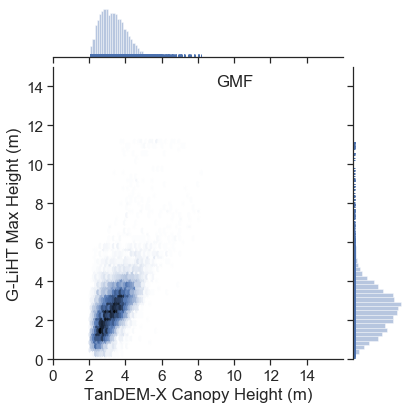

In [163]:
hexjointplot(groupedTDX_gliht_gmf, 'GMF')

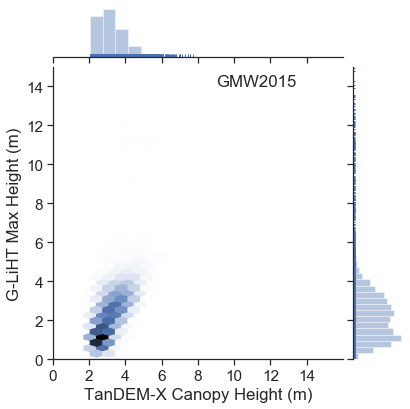

In [164]:
hexjointplot(groupedTDX_gliht_gmw2015, 'GMW2015')

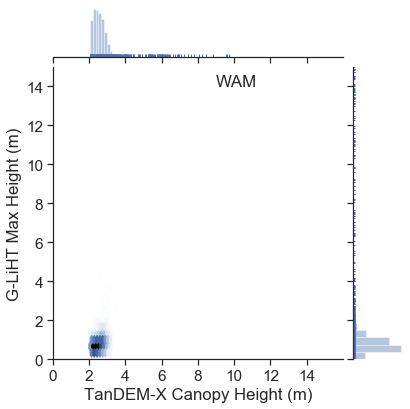

In [166]:
hexjointplot(groupedTDX_gliht_wam, 'WAM')

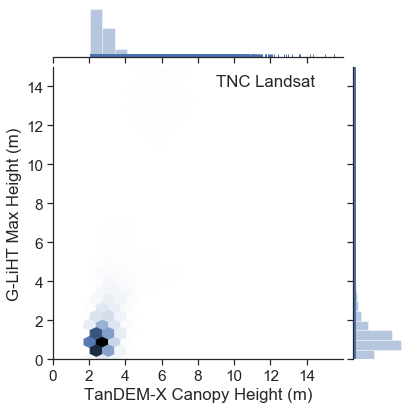

In [167]:
hexjointplot(groupedTDX_gliht_tnclandsat, 'TNC Landsat')

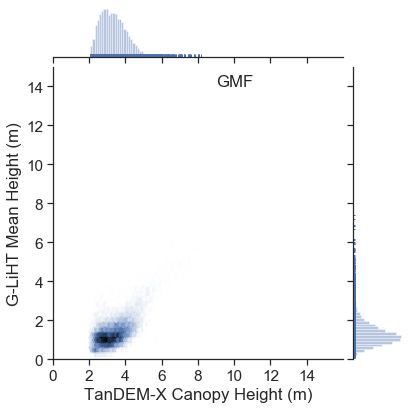

In [168]:
hexjointplot(groupedTDX_gliht_gmf, 'GMF', yatt='mean_z', ylabl="G-LiHT Mean Height (m)")

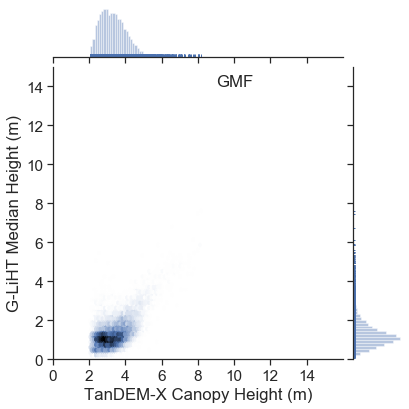

In [169]:
hexjointplot(groupedTDX_gliht_gmf, 'GMF', yatt='median_z', ylabl="G-LiHT Median Height (m)")

In [170]:
def linear_regress(df, x_att, y_att, fi=True):
    linear_regressor = LinearRegression(fit_intercept=fi)  # create object for the class
    X = df[x_att].values.reshape(-1, 1)
    Y = df[y_att].values.reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='orange')
    plt.xlabel(x_att)
    plt.ylabel(y_att)
    plt.show()

    r_sq = linear_regressor.score(X, Y)
    print("R squared:", r_sq)
    intercept = linear_regressor.intercept_
    print("intercept:", intercept)
    slope = linear_regressor.coef_
    print("slope:", slope)
    rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
    print("RMSE:", rmse)

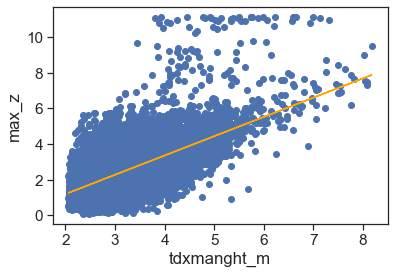

R squared: 0.4101158999814307
intercept: [-0.98628192]
slope: [[1.08407371]]
RMSE: 0.9799370118522528


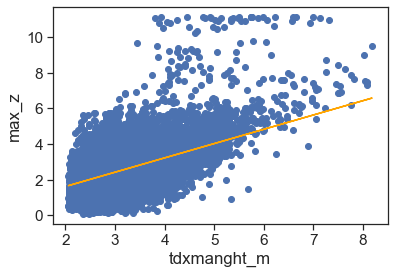

R squared: 0.3813515738906532
intercept: 0.0
slope: [[0.80396942]]
RMSE: 1.0035448168654482


In [171]:
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'max_z', False) # define intercept as 0

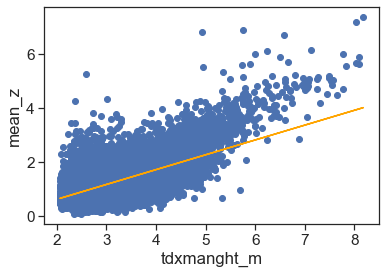

R squared: 0.3796667518031017
intercept: [-0.49455732]
slope: [[0.55092615]]
RMSE: 0.5307792552346803


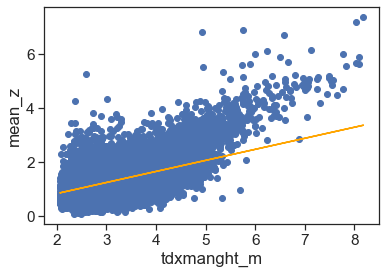

R squared: 0.35374214705041174
intercept: 0.0
slope: [[0.41047176]]
RMSE: 0.5417567461811359


In [172]:
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'mean_z', True)
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'mean_z', False) # define intercept as 0

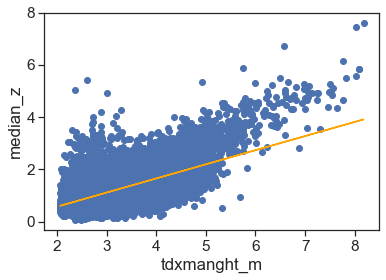

R squared: 0.35489245202810055
intercept: [-0.51015567]
slope: [[0.54068779]]
RMSE: 0.5494441416517697


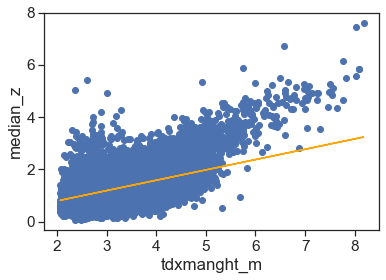

R squared: 0.3281209858287829
intercept: 0.0
slope: [[0.39580346]]
RMSE: 0.5607290077083331


In [173]:
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'median_z', True)
linear_regress(groupedTDX_gliht_gmf, 'tdxmanght_m', 'median_z', False) # define intercept as 0

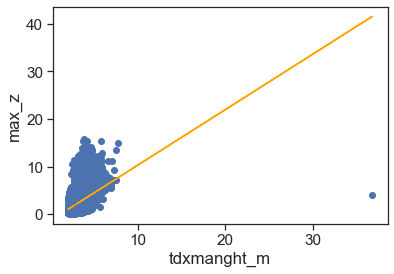

R squared: 0.35561753836734167
intercept: [-1.41705576]
slope: [[1.16891994]]
RMSE: 1.1827345343543831


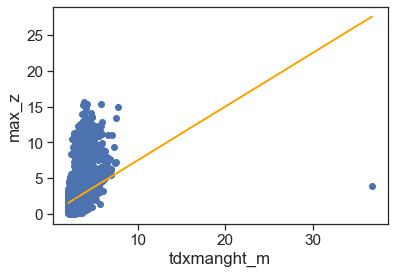

R squared: 0.30741137079561
intercept: 0.0
slope: [[0.74991186]]
RMSE: 1.2261768165284388


In [174]:
linear_regress(groupedTDX_gliht_gmw2015, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_gmw2015, 'tdxmanght_m', 'max_z', False) # define intercept as 0

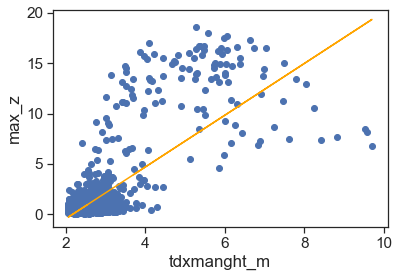

R squared: 0.5463551446692498
intercept: [-5.55535389]
slope: [[2.56385183]]
RMSE: 1.405874080461164


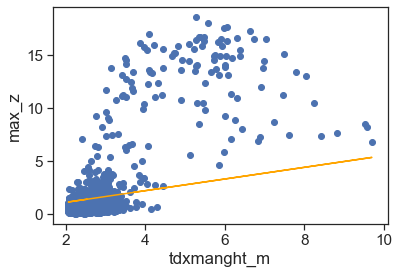

R squared: 0.19125674883902322
intercept: 0.0
slope: [[0.54937754]]
RMSE: 1.8771274640793865


In [175]:
linear_regress(groupedTDX_gliht_wam, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_wam, 'tdxmanght_m', 'max_z', False) # define intercept as 0

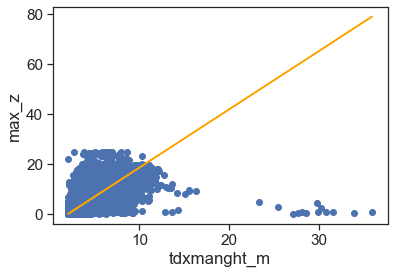

R squared: 0.617874193562882
intercept: [-4.74931395]
slope: [[2.33198534]]
RMSE: 2.4240674923071714


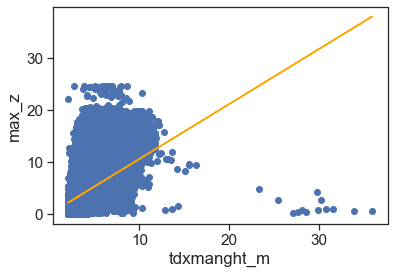

R squared: 0.40223041197119347
intercept: 0.0
slope: [[1.05960999]]
RMSE: 3.0318550308005223


In [176]:
linear_regress(groupedTDX_gliht_tnclandsat, 'tdxmanght_m', 'max_z', True)
linear_regress(groupedTDX_gliht_tnclandsat, 'tdxmanght_m', 'max_z', False) # define intercept as 0

In [186]:
pts_gt0_gmf['tdxmanght_m'].describe()

count    976953.000000
mean          3.711789
std           0.743551
min           2.060880
25%           3.211182
50%           3.658088
75%           4.131692
max           8.178864
Name: tdxmanght_m, dtype: float64

In [185]:
pts_gt0_gmw2015['tdxmanght_m'].describe()

count    997533.000000
mean          3.638619
std           0.729042
min           2.060898
25%           3.133476
50%           3.605617
75%           4.081502
max          36.775532
Name: tdxmanght_m, dtype: float64

In [184]:
pts_gt0_wam['tdxmanght_m'].describe()

count    49093.000000
mean         3.065858
std          1.144884
min          2.060199
25%          2.468967
50%          2.727163
75%          3.027381
max          9.705563
Name: tdxmanght_m, dtype: float64

In [193]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pts_gt0_tnclandsat['tdxmanght_m'].describe()

count   3469869.00000
mean          4.39715
std           1.78152
min           2.06000
25%           3.01951
50%           3.76250
75%           5.61635
max          35.88918
Name: tdxmanght_m, dtype: float64

In [194]:
pd.reset_option('display.float_format')